# Beat Tracking

## Imports

In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from matplotlib import pyplot as plt
import numpy as np

from scipy.signal import medfilt as medfilt
from scipy.ndimage import maximum_filter1d as maxfilt

import mir_eval

## Loading file

First applying and demonstrating the pipeline for one file, towards the end will run for a set of files for a generalized evaluation

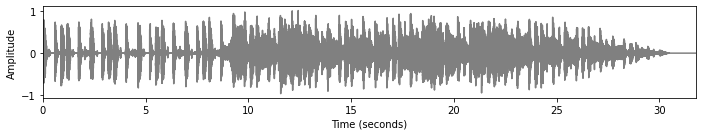

In [2]:
path_data = '../ballroom-data/'

# For now just testing with one
audio_file = path_data+'/Rumba-International/Media-105611.wav'

# Load audio
x, sr = librosa.load(os.path.join(audio_file))  # sampled at a rate of 22050 Hz
ipd.display(ipd.Audio(x,rate=sr))

# Plot audio
t1 = np.arange(x.shape[0]) / sr
plt.figure(figsize=(10, 2))
plt.plot(t1, x, color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t1[0], t1[-1]])
plt.tight_layout()

## Onset Detection

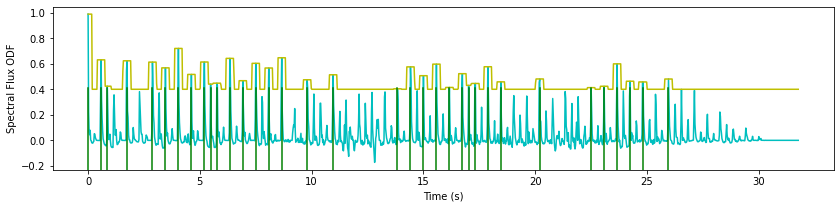

In [20]:
n = 2048
window = 'hann'
hop_length = 512

width = 15
threshold=0.4

def detect_onsets(x, width, threshold):
    # Short Fast Fourier Transform for spectrogram of audio
    D = np.abs(librosa.stft(x, n_fft=n, window=window, hop_length=hop_length))  # STFT
    D_transp = D.transpose()
    
    # Initialise variables for iterating
    frames = len(D_transp)
    odf = np.zeros(frames)  # stores odf spectral values for insinuating onsets
    bins = len(D)
    prev_magnitude = np.zeros(bins)  # stores magnitude of previous frame
    
    # Iterate through frames, process data via spectral flux
    for i, frame in enumerate(D_transp):
        magnitude = np.abs(frame)
        
        has_greater_magnitude = np.greater(magnitude, prev_magnitude)
        diff_magnitude = np.subtract(magnitude, prev_magnitude)
        
        spectral_flux = np.mean(np.multiply(has_greater_magnitude, diff_magnitude))
        odf[i] = spectral_flux
        
        prev_magnitude = magnitude
        
    # Normalise with respect to maximum odf value
    mx = max(odf)
    if mx > 0: odf /= mx
        
    # Computing peak times by filtering and thresholding
    hop_time = hop_length / sr
    t = np.arange(len(odf)) * hop_time
    odf_med = odf - medfilt(odf, width)
    odf_max = maxfilt(odf_med, width, mode='nearest', axis=0)
    
    thresholds = [max(i, threshold) for i in odf_max]
    peak_args = np.nonzero(np.greater_equal(odf_med, thresholds))
    peak_times = peak_args[0] * hop_time
    
    plt.figure(figsize=(14, 3))
    plt.xlabel('Time (s)')
    plt.ylabel('Spectral Flux ODF')
    plt.plot(t, odf_med, 'c')
    plt.plot(t, thresholds, 'y')
    for p in peak_times:
       plt.axvline(p, ymax=0.5, color='g')
    
    return peak_times
    
onsets = detect_onsets(x, width=width, threshold=threshold)

## Time Interval Histogram

0.577667164426745

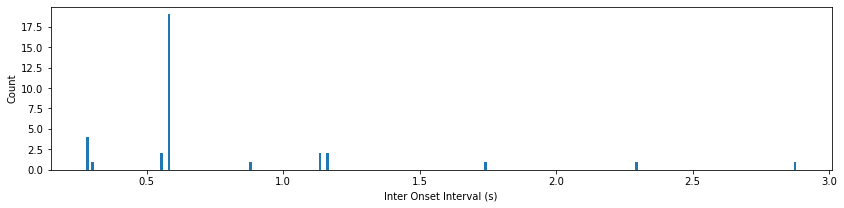

In [4]:
def find_common_ioi(onsets):
    ioi = []
    for i in range(1, len(onsets)):
        ioi.append(onsets[i] - onsets[i-1])

    plt.figure(figsize=(14, 3))
    plt.xlabel('Inter Onset Interval (s)')
    plt.ylabel('Count')
    
    n_bins = int(max(ioi) * 10 ** 2)  # Setting a bin per point in 2 d.p. since RT is 0.17s
    hist = plt.hist(ioi, bins=(n_bins))  
    ioi_common =  hist[1][np.argmax(hist[0])]
    return ioi_common

ioi_common = find_common_ioi(onsets)
ioi_common

## Periodicity function

In [5]:
def ioi_periodicity(ioi_common):
    tempo = 60 / ioi_common
    samples_per_beat = 60 * (sr/hop_length) / tempo
    return int(tempo), int(samples_per_beat)

tempo, spb = ioi_periodicity(ioi_common)
tempo, spb

(103, 24)

## Prediction

In [18]:
def estimate_beats(onsets, arg_start, ioi_common):
    start = onsets[arg_start]
    max_time = len(x) / sr
    estimated_beats = []
    new_beat = 0

    while new_beat < max_time:
        if len(estimated_beats) == 0:
            estimated_beats.append(start)
        else:
            prev = estimated_beats[-1]
            new_beat = prev + ioi_common
            estimated_beats.append(round(new_beat,2))  # rounding to 2 d.p.
            
    return np.array(estimated_beats[:-4])

estimated_beats = estimate_beats(onsets, 0, ioi_common)
estimated_beats

array([ 0.  ,  0.58,  1.16,  1.74,  2.32,  2.9 ,  3.48,  4.06,  4.64,
        5.22,  5.8 ,  6.38,  6.96,  7.54,  8.12,  8.7 ,  9.28,  9.86,
       10.44, 11.02, 11.6 , 12.18, 12.76, 13.34, 13.92, 14.5 , 15.08,
       15.66, 16.24, 16.82, 17.4 , 17.98, 18.56, 19.14, 19.72, 20.3 ,
       20.88, 21.46, 22.04, 22.62, 23.2 , 23.78, 24.36, 24.94, 25.52,
       26.1 , 26.68, 27.26, 27.84, 28.42, 29.  , 29.58])

## Results

OrderedDict([('F-measure', 0.4186046511627907),
             ('Cemgil', 0.22156153751560415),
             ('Cemgil Best Metric Level', 0.22156153751560415),
             ('Goto', 0.0),
             ('P-score', 0.7906976744186046),
             ('Correct Metric Level Continuous', 0.5581395348837209),
             ('Correct Metric Level Total', 0.6046511627906976),
             ('Any Metric Level Continuous', 0.5581395348837209),
             ('Any Metric Level Total', 0.6046511627906976),
             ('Information gain', 0.3780121605375617)])

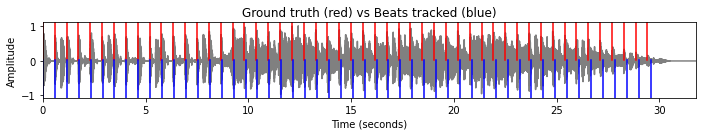

In [21]:
path_data = '../ballroom-annotations/'

# For now just testing with one
annotations_file = path_data+'Media-105611.beats'

def plot_play(true_beats, estimated_beats, x):
    # Audio player
    y = librosa.clicks(times=estimated_beats, sr=sr, length=len(x))
    ipd.Audio(x + y, rate=sr)

    # Plot audio
    t1 = np.arange(x.shape[0]) / sr
    plt.figure(figsize=(10, 2))
    plt.plot(t1, x, color='gray')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.xlim([t1[0], t1[-1]])
    plt.title('Ground truth (red) vs Beats tracked (blue)')
    plt.tight_layout()

    for b in true_beats:
       plt.axvline(b, ymin=0.5, color='r')
    for b in estimated_beats:
       plt.axvline(b, ymax=0.5, color='b')  

    
beat_annotations = np.genfromtxt(annotations_file, delimiter=' ')
true_beats = beat_annotations.transpose()[0]
plot_play(true_beats, estimated_beats, x)
mir_eval.beat.evaluate(true_beats, np.array(estimated_beats))